In [ ]:
#@title Install Kaolin

!pip install kaolin==0.13.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-1.13.1_cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-1.13.1_cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.2/427.2 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 KB 15.9 MB/s eta 0:00:00
  Attempting uninstall: tornado
    Found existing installation: tornado 6.2
    Uninstalling tornado-6.2:
      Successfully uninstalled tornado-6.2
  Attempting uninstall: flask
    Found existing installation: Flask 2.2.3
    Uninstalling Flask-2.2.3:
      Successfully uninstalled Flask-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.

In [ ]:
#import modules

import torch
import kaolin as kal
import numpy as np
from PIL import Image

device = torch.device('cuda:0')

In [ ]:
#@title get camera params from elevation, azimuth, radius
def get_camera_from_view(elev, azim, r=3.0):
    x = r * torch.cos(elev) * torch.cos(azim)
    y = r * torch.sin(elev)
    z = r * torch.cos(elev) * torch.sin(azim)

    pos = torch.tensor([x, y, z]).unsqueeze(0)
    look_at = -pos
    direction = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(0)

    camera_proj = kal.render.camera.generate_transformation_matrix(pos, look_at, direction)
    return camera_proj

In [ ]:
#Mesh class

class Mesh:
  def __init__(self, obj_path):
     mesh = kal.io.obj.import_mesh(obj_path, with_normals = True)
     self.vertices = mesh.vertices.to(device)
     self.faces = mesh.faces.to(device)
     self.vertex_normals = mesh.vertex_normals.to(device)
     self.normalize_mesh()
    
  def normalize_mesh(self):
    center = self.vertices.mean(dim = 0)
    v = self.vertices - center
    scale = torch.norm(v, dim = 1).max()
    v /= scale
    self.vertices = v

In [ ]:
#Render single image from Mesh
lights = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).to(device)
camera_projection =kal.render.camera.generate_perspective_projection(np.pi / 3).to(device)
dim = (224, 224)
def render_single_view(mesh, elev=0, azim=0, show=False, lighting=True, background=None, radius=2,
                        return_mask=False):
    # if mesh is None:
    #     mesh = self._current_mesh
    verts = mesh.vertices
    faces = mesh.faces
    n_faces = faces.shape[0]

    face_attributes = torch.ones(1, n_faces, 3, 3).to(device) * 0.5


    camera_transform = get_camera_from_view(torch.tensor(elev), torch.tensor(azim), r=radius).to(device)
    face_vertices_camera, face_vertices_image, face_normals = kal.render.mesh.prepare_vertices(
        mesh.vertices.to(device), mesh.faces.to(device), camera_projection, camera_transform=camera_transform)

    image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
        dim[1], dim[0], face_vertices_camera[:, :, :, -1],
        face_vertices_image, face_attributes, face_normals[:, :, -1])


    image = torch.clamp(image_features, 0.0, 1.0)
    if lighting:
        image_normals = face_normals[:, face_idx].squeeze(0)
        image_lighting = kal.render.mesh.spherical_harmonic_lighting(image_normals, lights).unsqueeze(0)
        image = image * image_lighting.repeat(1, 3, 1, 1).permute(0, 2, 3, 1).to(device)
        image = torch.clamp(image, 0.0, 1.0)

    return image

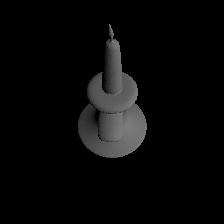

In [ ]:
mesh = Mesh('./candle.obj')
image = render_single_view(mesh, elev = np.pi / 3)

Image.fromarray((image.squeeze(0).cpu().numpy() * 255.).astype('uint8'))